# CS2311-Data Structures and Algorithms in Python
## Homework 8  - Green Screen ML program
## Due Date: See BlackBoard

## Student Name: 

**SUBMISSION GUIDELINES**

1. First design, develop and test your code in a Jupyter notebook or other development environment
   - You can expirement and try different things in this notebook
2. Then copy your final code and markdown cells into the Jupyter Notebook file (.ipynb) provided for the assignment and submit to Blackboard
   - **Your submission file should be named HW8GreenScreen.ipynb**
   - I must be able to open and run your notebook in order to grade it
3. Note that the Jupyter notebook provided for final submission may contain testing code to help you check that your output and expected match.  
   - Follow the instructions in the notebook for copying your code and running the testing code
   - The instructor may run additional tests to check that your code runs correctly
4. If asked, also provide any supporting files or images requested in the assignment
   - If there are multiple files to submit you should zip the files into one folder and submit the folder

**GRADING CRITERIA:**
1. Good documentation/comments and program readability using both markdown cells and code comments
2. Algorithm/pseudo-code is explained in a markdown cell and is efficiently written
3. Program runs correctly for test cases with no syntax errors or logical errors

***The instructor should be able to reproduce your work from your notebook.***

# Elements of Machine Learning - Green Screen program

We'll do a simple greenscreen replacement with a machine-learning model.

In the following code cells, we will:
- download and display an image
- pre-process the pixels, labeling background and foreground pixels
- train a model to identify green background pixels
- use the predictions of the model to swap the green screen background for an image of Van Gogh's Starry Night 

We will be using the preprocessing module for image processing from the keras library.  Keras is powerful and commonly used library used for deep learning. 

### Installing keras.preprocessing
From the anaconda command prompt type
> `conda install -c conda-forge keras-preprocessing`
* Windows users **should run the Anaconda Prompt as an Administrator**

In [1]:
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


Display the studio green screen image using Keras

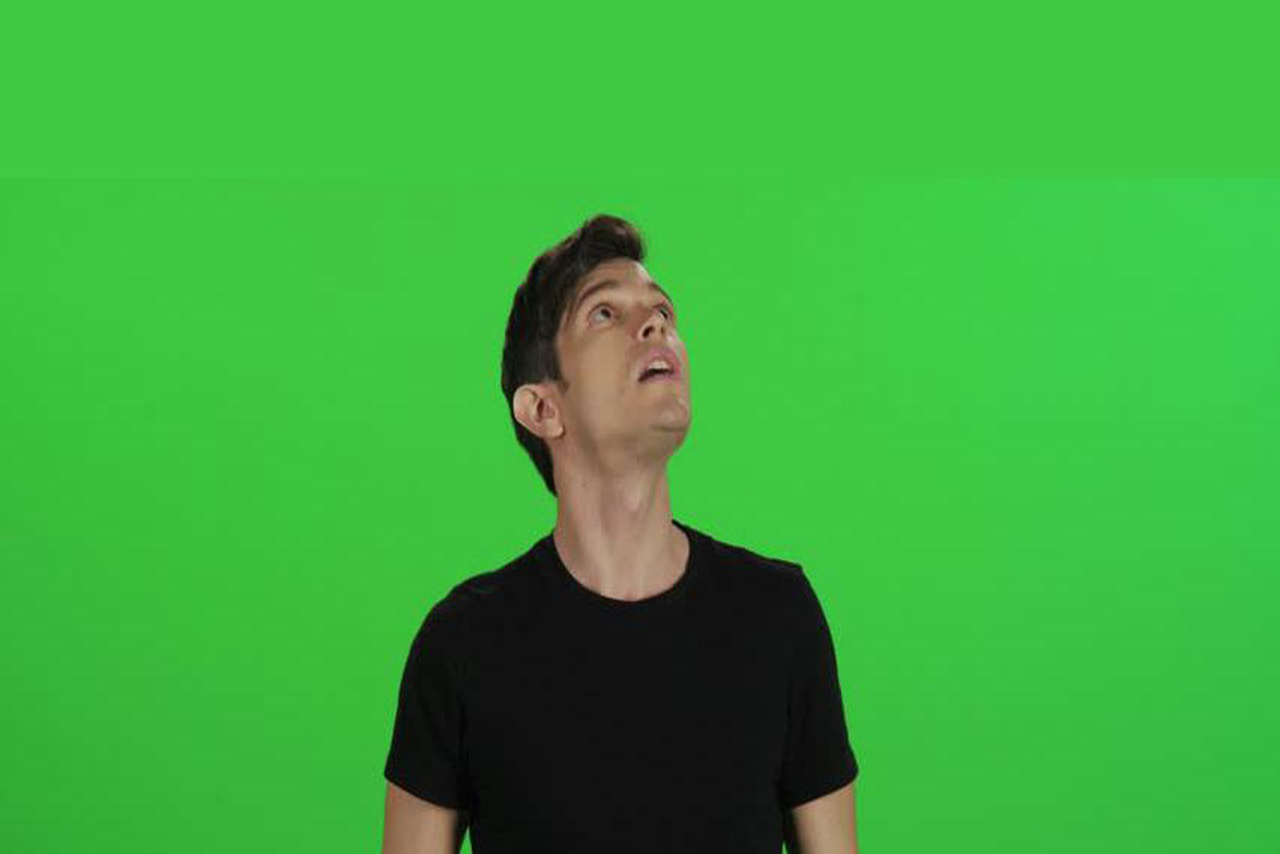

In [2]:
img = image.load_img("imgs//sample_studio_image3.jpg")
display(img)

Check the size of the image in terms of (x,y) pixels.  The size of the studio image and background image don't need to be of the same size for the superpostion to work, but it makes the code simpler.  The images provided for this assignnmet are of the same size.  If you are using your own images and the sizes are different then resize both images to be the same size.  See the utility Jupyter notebook that has been provided if you want to use a different background image and need to re-size it. You can also google "resizing images in python" for other ways to do this.  Or if you can also make your drawScreen() code more sophisticated to handle different size background and studio images.

In [3]:
# image size
img.size

(1280, 854)

Notice if the image has some unwanted pixels. If so you can crop the image and display the cropped version.  First conver the image to a 3D numpy array - (x,y,RGB) and inspect the size of the array using `.shape`

In [4]:
arr = image.img_to_array(img)

In [5]:
# array shape
arr.shape

(854, 1280, 3)

**Note:** Trim the unwanted pixels from the array using array slicing operations. In this case we will keep all rows and columns of the image.

You can display the array as an image using `image.array_to_image()`

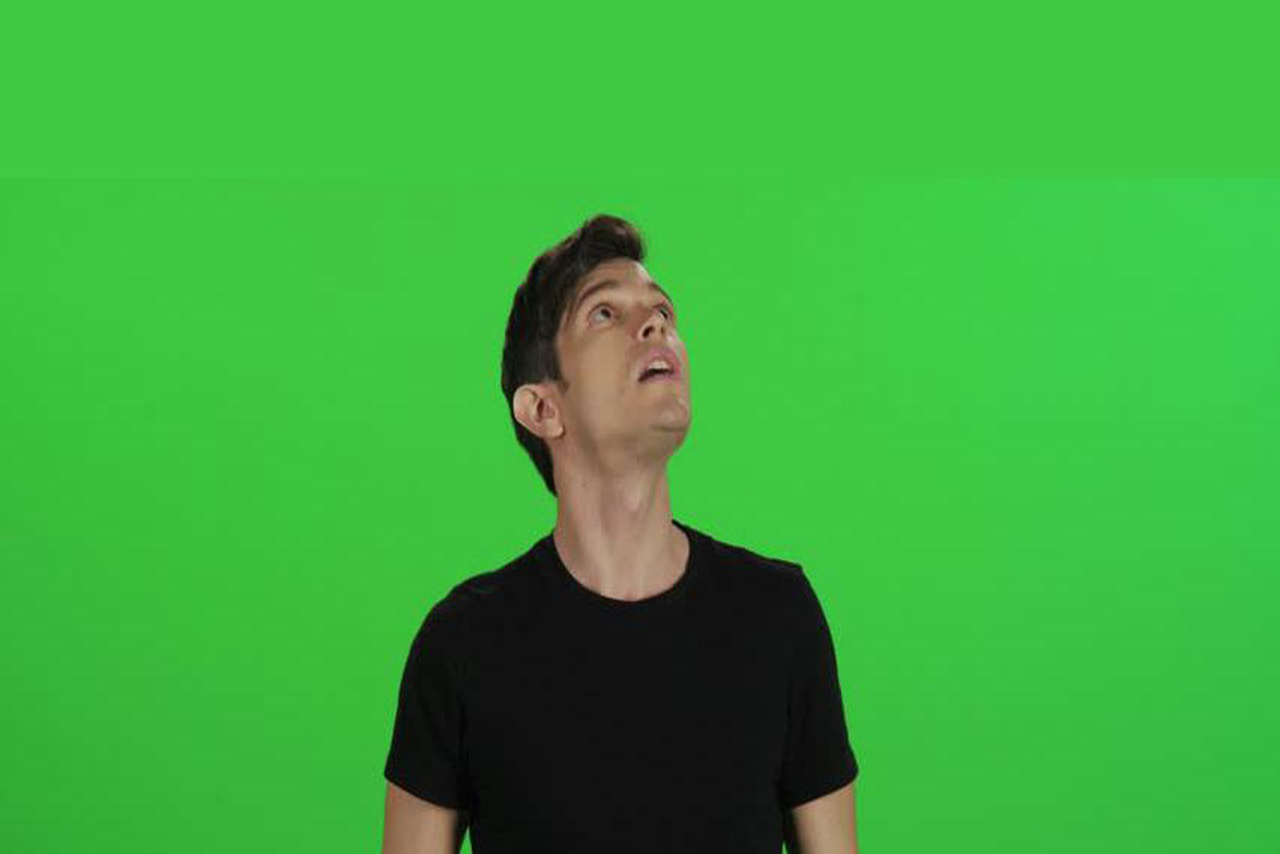

In [6]:
#displayy image from array
display(image.array_to_img(arr,scale=False))

### The Background Image

We will use a Van Gogh Starry Night background.

We display the image of the painting, `img` and covert the image into an array, `bkg`.

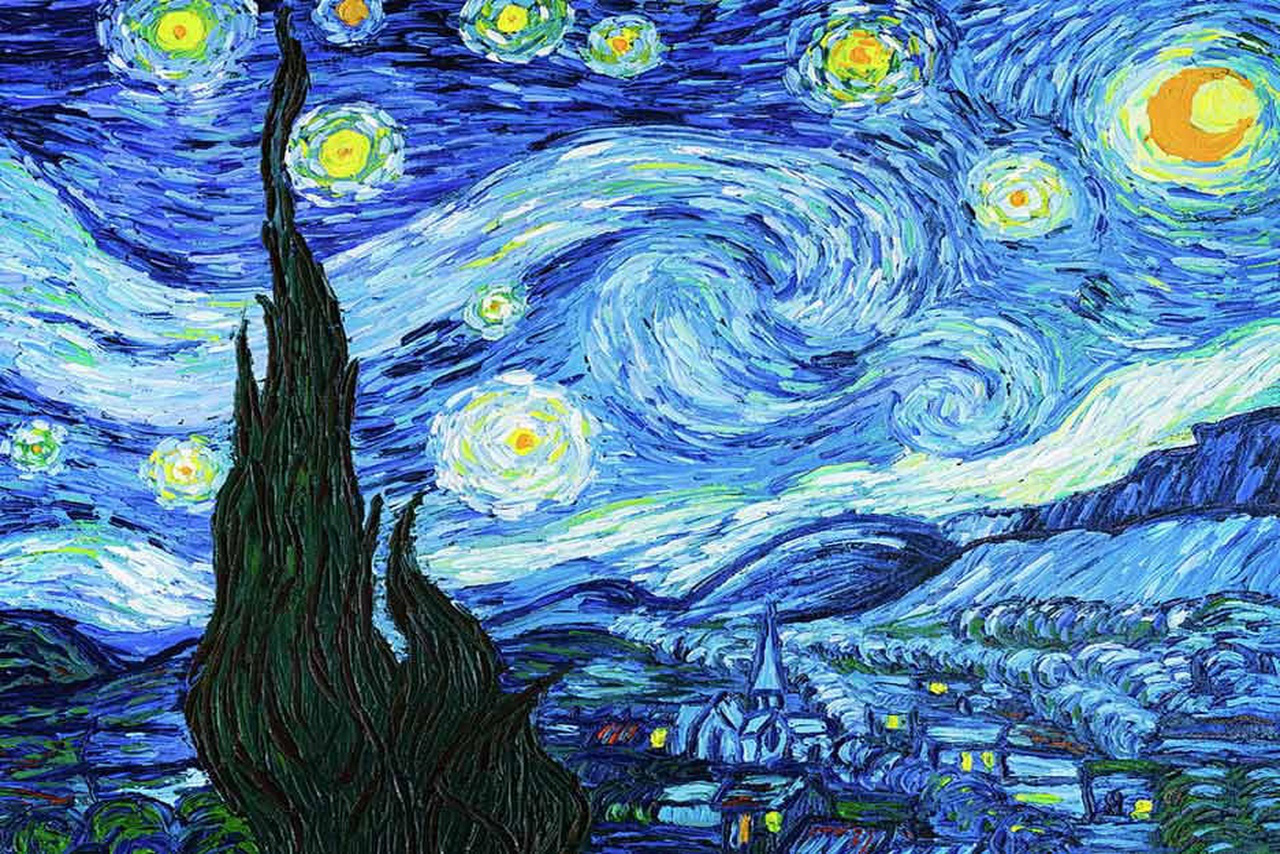

In [7]:
# display background image
img = image.load_img("imgs//Starry_Night_Van_Gogh_scaled.jpg")
display(img)

Inspect the size of the image.

In [8]:
# image size
img.size

(1280, 854)

Convert the image to a 3D numpy array and inspect the shape of the array

In [9]:
# save image to array
bkg = image.img_to_array(img)

In [10]:
# shape of background image
bkg.shape

(854, 1280, 3)

## Preparing Data Examples of Green "YesSet" and not Green "No Set" for the Learner
Next we need to create examples of data that represent "Green" and "Not Green" for the machine learner to be able to learn by calculating the loss for any given rule over the set of examples provided.  We will construct a "loss function" to evaluate our rules and a simple "optimizer" later in the program.

### Green Examples - YesSet
Isolate part of the background and make a dataset of background green pixels, this is the `YesSet`.  

Try selecting the first 250 columns of the image array. Check the size and display the subset image.  You should see just a strip of green pixels. Keep in mind that there may be different RGB greens here even if not apparent to the eye.  Also not that this may not be pure green i.e. RGB = 0,255,0.  Hence, we will need to train our learner to identify the green from our green screen.

In [11]:
# background green pixels
tmp = arr[0:854,0:250]

In [12]:
# shape of array
tmp.shape

(854, 250, 3)

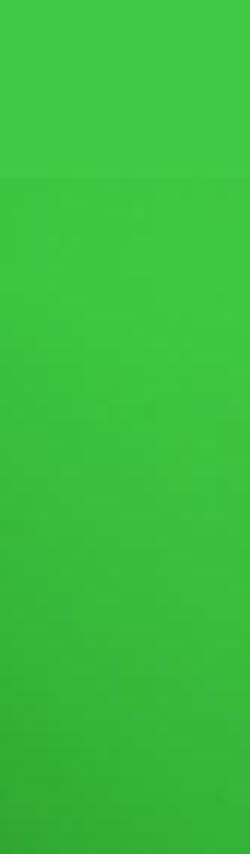

In [13]:
# display array as image
display(image.array_to_img(tmp,scale=False))

Now use `.reshape` to convert the array into a 2D array of individual pixels and their color. We are going to learn by going pixel by pixel and comparing the color of our pixel vs the "best" selection of prototype color "c" and distance neighborhood "d" based on the feedback from our loss function.  

To use `.reshape()` pass in the dimensions you want to shape to.  **Hint**: a fast way to keep only the RGB dimension is to pass in `(-1,3)` for the shape. This indicates to numpy to put the x,y into one column, without changing the 3 (RGB) dimension.

In [14]:
# YesSet
YesSet = np.reshape(tmp,(-1,3))

Print the number dimensions of `tmp` using `.shape` - 3D

In [15]:
# array shape
tmp.shape

(854, 250, 3)

Print the dimensions of `YesSet` using `.shape` - 2D

In [16]:
# YesSet shape
YesSet.shape

(213500, 3)

Let's see what the **"average"** green pixel RGB looks like from the "green" examples.  For this you can calculate the mean using `.mean()` across the columns of the YesSet.

In [17]:
# Yes set mean by color
YesSet.mean(axis=0)

array([ 58.479282, 191.82841 ,  61.937107], dtype=float32)

You can also calculate the average deviation, i.e. the standard deviation across the three colors.  Notice that the deviation is pretty small so the "green" is pretty consistent, so to speak.

In [18]:
# YesSet standard deviation by color
YesSet.std(axis=0)

array([4.214092, 8.758113, 4.861634], dtype=float32)

### Non-Green Examples - NoSet
Now we need data examples of "Not Green" for the learner so we will use a part of the image that does not have green pixels for our examples.

Isolate part of the foreground and make a dataset of foreground pixels called `NoSet`.  

Try selecting rows 250 to end and columns 560 to 640 of the image array. This slice has no "green" pixels.  Display the image of the array to make sure you have mostly non-green data examples.

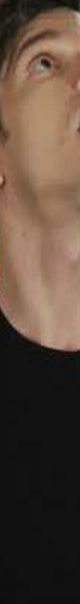

In [19]:
# foreground
tmp  = arr[250: ,560:640]
display(image.array_to_img(tmp,scale=False))

as before use `.reshape()` to convert the 3D array into a 2D array with the 3rd dimension unchanged.

In [20]:
# NoSet reshape
NoSet = np.reshape(tmp,(-1,3))

Dimensions of the full image, corresponding to the height, width, and RGB (red, green, blue) colors.

In [21]:
# NoSet shape
NoSet.shape

(48320, 3)

### Finalize the data set and labels for training the learner

We finalize our dataset, with a variable `alldat` cointaining our list of all pixels, and `labs` holding our list of all labels for each pixel (`1` for green background pixels and `0` for foreground pixels).  For this step use `np.concatenate()` on the YesSet and NoSet.

In [22]:
# Build a list of pixels for both positive and negative examples.
alldat = np.concatenate((YesSet,NoSet))

In [23]:
alldat

array([[ 64., 201.,  69.],
       [ 64., 201.,  69.],
       [ 64., 201.,  69.],
       ...,
       [ 17.,  17.,  17.],
       [ 17.,  17.,  17.],
       [ 17.,  17.,  17.]], dtype=float32)

to create the labels concatenate a 1D array of ones of length equal to the YesSet (green pixels or background) and a 1D array of zeros of length equal to the length of the NoSet(non-green or foreground).  You can use `np.concatenate()` and `np.ones()`, `np.zeros()` and the `len()` function.

In [24]:
# labels
labs = np.concatenate((np.ones(len(YesSet)), np.zeros(len(NoSet))))

Take a look at the `alldat` and `labs` arrays

In [25]:
alldat

array([[ 64., 201.,  69.],
       [ 64., 201.,  69.],
       [ 64., 201.,  69.],
       ...,
       [ 17.,  17.,  17.],
       [ 17.,  17.,  17.],
       [ 17.,  17.,  17.]], dtype=float32)

In [26]:
labs

array([1., 1., 1., ..., 0., 0., 0.])

## Program for the Loss Function

In order to learn the best "c" and "d" that minimizes the loss over the YesSet and NoSet examples we need to write a loss function that gives us feedback if the rule we are working with i.e. values for "c" and "d" result in a low loss score.  A perfect rule would have zero loss on every pixel inspected in the data set.  All greens would be correctly identified as green and all non-green as non-green.

For the loss function write a function `computeloss(c, d, YesSet, NoSet)` that:
- takes a value for c,d, the YesSet and the NoSet
- Initializes the loss to zero
- First goes through ALL the YesSet Pixels and if the distance "d" of the pixel color in the YesSet from "c" is greater than "d" increments the loss by +1 to indicate a miss for this rule.
- Next goes through ALL the NoSet Pixels and if the distance "d" of the pixel color in the NoSet from "c" is less than "d" increments the loss by +1 to indicate a miss for this rule.
- The function return the total loss calculated for this rule on all the YesSet and NoSet pixels.

The distance is calculated using Eucledian Distance (i.e. pythagorean theorem) and the function is given below.

In [27]:
import math

def distance(c1, c2):
    return(math.sqrt(  (c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2 ) )

 Write the compute loss function and test it.

In [28]:
# Compute loss function
def computeloss(c, d, YesSet, NoSet):
    # initially, the loss count is zero
    loss = 0
    # Loop through all the pixels in the yes set 
    for c1 in YesSet:
        # if the color c1 in the YesSet is more than d units away 
        # from the prototype color d, then the rule would say "no"
        # for this example, which is wrong. We add one to the loss function.
        if distance(c, c1) > d:
            loss = 1 + loss
    # next, we loop through each color c1 in the NoSet.
    for c1 in NoSet:
        # Now, the logic is reversed.  If c1 and the prototype c
        # are CLOSER than or equal to d, the rule will say "yes",
        # which would be a mistake. We add one to the loss in this case, too.
         if distance(c, c1) > d:
            loss = 1 + loss 
    
    # return the loss as computed over all of the labeled examplabses
    return loss

Now test your loss function by running it against a few colors. Here we create a list of color labels, RGB codes, and a guess distance "d".  We will see what compute_loss() gives us on these different prototype colors and distances.

In [29]:
# test the loss function 
params = []
params.append(("blue",np.array([0,0,255]),math.sqrt(100_000)))          
params.append(("green",np.array([0,255,0]),math.sqrt(10_000)))
params.append(("green",np.array([0,255,0]),math.sqrt(9_000)))
params.append(("green",np.array([0,255,0]),math.sqrt(1_000)))
params.append(("off green",np.array([60,200,60]),math.sqrt(1000)))

In [30]:
# inspect params list
params

[('blue', array([  0,   0, 255]), 316.22776601683796),
 ('green', array([  0, 255,   0]), 100.0),
 ('green', array([  0, 255,   0]), 94.86832980505137),
 ('green', array([  0, 255,   0]), 31.622776601683793),
 ('off green', array([ 60, 200,  60]), 31.622776601683793)]

Let's `manually` optimize c and d. There are billions of possible c and d combinations to try!! How do we choose? 

In [44]:
# Manually try to optimize c and d
print(format("Color",'11s')+format("RGB",'20s')+format("Sqrd Dist",'10s')+format("Loss",'>10s'))
for color,code,dist in params:
    loss = 
    print(format(color,'10s'),format(str(code),'20s'),format(dist**2,'8,.0f'),format(loss,'10,.0f'))

SyntaxError: invalid syntax (<ipython-input-44-98323d365d7a>, line 4)

The optimizer program would search for the best c and d rule that minimizes the loss over the representational space. To keep it simple we are going to "cheat" a bit based on our knowledge of the problem and see if we can optimize over only the d variable.

What is a good guess for c? (**Hint**: remember our mean and standard deviation calculation for the YesSet above?)

Test the compute_loss() function with your guess for c and use d = sqrt(500) for now. We can then write an optimizer to minimize over different values of d.

In [ ]:
# Test loss function with educated guess on c
params = []
guess = [?, ? , ?]
params.append(("Green Guess",math.sqrt(500)))

print(format("Color",'11s')+format("Sqrd Dist",'10s')+format("Loss",'>10s'))
for color,dist in params:
    loss = compute_loss(guess, sqrt(500), )
    print(format(color,'10s'),format(dist**2,'8,.0f'),format(loss,'10,.0f'))

## Simple Optimizer Program for d over a Range

Now with the problem simplified, write a simple optimizer that takes c,YesSet,NoSet,min_d and max_d and returns the d value that minimizes the loss function.

You can do this several ways:  Write a loop to find the d that gives a minimum loss, do a binary search algorithm i.e. pick a mid-point and continue searching for the minimum loss, or simply test the loss over a sample of values.  The loop and sampling will be slower (okay for this small problem).  The binary search is faster and closer to what real optimizers do.

Let's build the optimizer in two ways: 
- 1) Search over a sample of d values 
- 2) write a binary search function to find the minimum of the loss function - look for the value of d a which the slope of the loss function is zero (remember calculus?)

### Optimizer 1) Search over a sample of d values and select a good one

For this part reuse part of the code we used previously to test the computeloss() function.  Write a for loop that calculates the computeloss() function over the sample values of d in the list provided.  Your code should do the following:
- set up an empty params list
- set up your guess_c = [?,?,?]
- set up sample_d = [100_000,50_000,25_000,12_500,4700,3000,1000,500,250,125,50,25_000]
- for d in the sample_d list
    - compute the loss
    - print out the output in a table similar to the one shown
- look at the table and select a value of d that minimizes the loss

In [ ]:
#Optimizer code here - Using sampling
guess_c = [ ?, ?  ,  ?]
sample_d = [100_000,50_000,25_000,12_500,4700,3000,1000,500,250,125,50,25]

print(format("Color",'11s')+format("Sqrd Dist",'10s')+format("Loss",'>10s'))

for __________:
    loss = computeloss(guess_c,math.______(?),?,?)
    print(format("Green Guess",'10s'),format(d,'8,.0f'),format(loss,'10,.0f'))

### Optimizer 2) Use binary search to find the minium of loss function (more challenging)

For your function write a function called `optimizer_binary(c,YesSet,NoSet,dmin=0,dmax=20_000)` that returns the optimal d value, given c, the YesSet, NoSet, and the range of values dmin to dmax to search over.

The function should do the following:
- set min to dmin, max to dmax, slope = 1
- find the midpoint and calculate the slope (rise over run) of the loss function i.e. (loss(sqrt(d+100))-loss(sqrt(d-100)))/200.  Remember that computeloss takes the sqrt(d) as an input that's why we need sqrt.
- if the slope is positive then loss is increasing as d goes up so search in the lower half i.e. set mid = max
- else search in the upper half i.e. set mid = min
- repeat the calculation in the reduced min to max range as long as the absolute value of the slope is > 0.01
- return the value of d (i.e. the last mid)

This is similar to what we did when studied the binary search algorithm except that we are doing this on a "function" derivative or slope.  Recall from calculus that the minumim occurs at the value of d where the slope is zero.

In [ ]:
# Optimizer code - using binary search
def optimizer_binary(c,YesSet,NoSet,dmin=0,dmax=25_000):
    ????
    while abs(slope) > 0.01:
        ????
        
    return mid

In [ ]:
# Test your function
guess_c = [ ?, ?  ,  ?]
bestd = optimizer_binary(guess_c,YesSet,NoSet)

In [ ]:
# bestd
bestd

## Question: What rule has your machine learner learned to be the best "c" and "d" in the space?

In [ ]:
# Your Answer
best_c = (?, ?  ,  ?)
best_d = math.sqrt(?)

## Program to Merge the Foreground and Background given best learned rule for "c" and "d"

Write a function `drawScreen(c, d, studio_image, background_image,bw = False)` for merging foreground and background. c,d are the best rule learned from the data, bw = True will draw the background white and the foreground black showing a silhouette of the image.

This will look similar to the compute_loss() code except that every x and y pixel will be either placed in the background or foreground based on the "c" and "d" rule that you have learned.  Black is RGB (0,0,0) and white is RGB (255,255,255).

The algorithm for `drawScreen(c, d, studio_image, background_image,bw = False)` should do the following:
- takes the best rule for c,d, the studio_image and the background_image
- Make a copy of the studio image to modify - use `display_image = studio_image.copy()` for this
- For x values in the range of the min(background image,studio_image)  # makes sure images overlap on x axis
- for y values in the range of the min(background image,dtudio_image)  # makes sure images overlap on y axis
- if distance of pixel (x,y) and c is less than d
    -   if not bw the display_image at x,y is the background image else display white
- else 
    -   if not bw the display_image at x,y is the studio image else display black
- convert the array to an image and display the superimposed image

In [ ]:
def drawScreen(c, d, studio_image, background_image,bw = False):
    
    # make a copy of the studio image and call it display image
    display_image = ___________._____()
    black = np.array([?,?,?])
    white = np.array([?,?,?])
    
    for x in range(?):
        for y in range(?):
            
            ???
    
    
    # display the array as image        
    __________(image.__________(?,scale=False))

## The Superimposed Image
Put ML into the background!

Display the studio image

In [ ]:
# display
????

Display the studio image in the background based on your learners best rule (this may take a few seconds since there are many pixels to process)

In [ ]:
# draw screen
drawScreen(best_c,best_d, arr, bkg, bw=False)

Now do just the black and white outline

In [ ]:
# draw outline
drawScreen(best_c,best_d, arr, bkg, bw=True)

## Have fun and try different backgrounds and foregrounds

Have fun - try your own images and maybe even green screen of yourself or others. You may have to modify your drawScreen() function to handle the case where the images are of different size or resize the images to be the same when you start.  You may also want to modify the function to specify where to locate the foreground on the background.  